# Irregular Matched Filter Vs others

We would like to see how our developed method (Irregular Matched Filter) perform compared with others methods, for examplem interpolation with Regular Matched Filter or directly Cross Correlation. In this step, we will not care about time complexity and just compare results data (time offset of the match) looking for the best (closest to theoretical result).

To check, we are going to use a micro lens simulated signal using real time samples, this is because it's hard to find a microlens TimeSeries with the related model parameters, so we create this parameters and thus the signal.

We are going to use an "optimal" configuration for the microlens (see [Micro Lens Study](./microLensStudy.ipynb)) in order to get the best Matched Filter results.

In [1]:
# imports
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import glob
import os
from sklearn.metrics import r2_score

import sys
sys.path.append("../../")
from imf.regressions import * #here it is the regression
from imf.types import FrequencySamples, TimeSeries, FrequencySeries, TimeSamples
from imf.transform.transform import FourierTransformer, FFTTransformer, RegressionTransformer
from imf.filter.mfilter import mfilter
from imf.filter.mf import matched_filter_core


### Data simulation

Match should happens at 1933.8289415 days


Text(0, 0.5, 'mag')

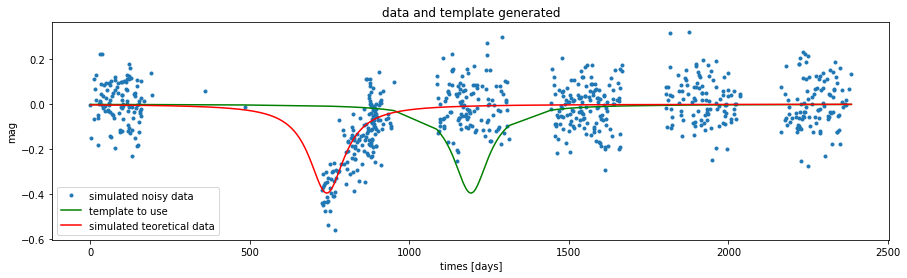

In [8]:
# read file
def read_file():
    # folder MLensing with the files should be placed out 
    # of the root file of the project (the one with the .git)
    return glob.glob("../../../MLensing/*.mjd")

days_to_sec = 1 * 24 * 60 * 60 # transformation from days to seconds
sec_to_days = 1 /(60 * 60 * 24) # transformation from seconds to days

def read_data(files, j, ini, end):
    a = pd.read_csv(files[j], skiprows=3, header=None, sep=" ") # read the table
    a.columns = ["MJD", "Mag", "err"] # name the columns
    times = TimeSamples(a["MJD"][ini:end]) # read the times in MJD
    times -= times.min() # normalize to 0, this give us units of days
    times *= days_to_sec # transform to units of seconds
    return times

def a_micro_lens(t0, times, noise=True):
    tE = 10
    fs = 33.2 
    U0 = 6.2
    u = np.sqrt(U0**2 + ((times - t0)  /tE )**2)
    A = (u**2 + 2.) / (u * np.sqrt(u**2 + 3))
    dm = - 2.5 * np.log10(fs*(A - 1) + 1)
    if noise:
        return TimeSeries(dm + np.random.normal(0, 0.1, len(times)), times=times)
    else:
        return TimeSeries(dm, times=times)



files = read_file()  # files names
j = 13 # the particular observation to use
ini = 0 # init of a range of the observations, we use the whole data
end = -1 # end of a range of the observation, we use the whole data
L = 123  # index of time used as t0 for data generation

times = read_data(files, j, ini, end)
times *= sec_to_days
data = a_micro_lens(times[L], times)
temp = a_micro_lens(times.duration/2, times, noise=False)

# compute the teorethical time of match
teo_match = max(times) + times[L] - times.duration/2
print("Match should happens at {} days".format(teo_match))
N = 800
teo_time = TimeSamples(np.linspace(0, times.max(), N))
teo_data = a_micro_lens(times[L], teo_time, noise=False)

plt.figure(figsize=(15, 4))
plt.plot(times, data, '.', label="simulated noisy data")
plt.plot(times, temp, 'g', label="template to use")
plt.plot(teo_time, teo_data, 'r', label="simulated teoretical data")
plt.legend()
plt.title("data and template generated")
plt.xlabel("times [days]")
plt.ylabel("mag")

## Irregular Matched Filter

Compute the Matched Filter using directly the unevenly TimeSeries of the data and template.

In [19]:
# create the frequency objective grid
def create_freq(times):
    nyq_freq = len(times) / times.duration / 2
    minf = 1 / times.duration #min freq, avoid 0
    freqs = FrequencySamples(input_time=times, minimum_frequency=minf, maximum_frequency=nyq_freq, samples_per_peak=1)
    freqs = FrequencySamples(initial_array=np.append(np.sort(-freqs.data), freqs.data), df=freqs.basic_df)
    return freqs

# instanciate the Regression and Transformer
def create_transformer(freq):
    reg = SGDRegression(alpha=1e-8, max_iter=1000, penalty='l2', l1_ratio=0.5, tol=0.001)
    return RegressionTransformer(reg=reg, freq=freq)

# Transform the data and template
def transform_all(data, template, tr):
    data_ft = data.to_frequencyseries(tr)
    template_ft = template.to_frequencyseries(tr)
    return data_ft, template_ft

# compute the PSD of the data
def compute_psd(data, freq):
    return data.psd(freq)

# compute the SNR
def compute_snr(times, data, template):
    freq = create_freq(times)
    tr = create_transformer(freq)
    d, t = transform_all(data, template, tr)
#     psd = compute_psd(data, freq)
    psd = None
    return matched_filter_core(times, d, t, tr, psd=psd)


snr = compute_snr(times, data, temp)

match happens at 1962.706168999997 days when should have happens at 1933.8289415 days
mean value of the absoulte SNR is 3.386973995817094 when should be approx 2


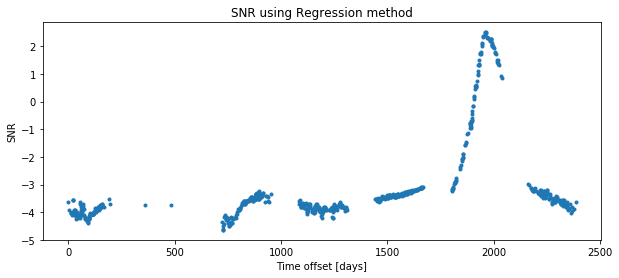

In [20]:
plt.figure(figsize=(10, 4))
plt.title("SNR using Regression method")
plt.xlabel("Time offset [days]")
plt.ylabel("SNR")
plt.plot(times, snr, '.')

print("match happens at {} days when should have happens at {} days".format(times[np.argmax(snr)], teo_match))
print("mean value of the absoulte SNR is {} when should be approx 2".format(np.mean(np.abs(snr))))

### Regular Matched Filter

An alternative method using Fast Fourier Transform instead of Regressions, to regilarize the grid, we perform an interpolation.
Altough liner interpolation is far from good, we use this due to his simplcity, but in the future we could use a better interpolation.

The main idea is, interpolate the time series, apply regular matched filter and the time offset could be interpolated back to irregular time samples if it's necessary.


In [22]:
# interpolate times
def interpolate(times, factor=2):
    return np.linspace(times.min(), times.max(), len(times) * factor)

# instanciate the transformer
def create_transformer2(interp_time):
    return FFTTransformer(interp_time)

# transform data and template
def transform_all2(data, template, tr):
    data_ft = data.to_frequencyseries(tr)
    temp_ft = template.to_frequencyseries(tr)
    return data_ft, temp_ft

# compute PSD of the data
def compute_psd2():
    pass

# compute SNR of the data
def compute_snr2(times, data, template):
    interp_time = interpolate(times, factor=2)
    tr = create_transformer2(interp_time)
    d, t = transform_all2(data, template, tr)
    psd = None
    return matched_filter_core(times, d, t, tr, psd=psd)

snr2 = compute_snr2(times, data, temp)

AttributeError: 'numpy.ndarray' object has no attribute 'average_fs'

### Cross Correlation

Behind the Matched filter, the SNR is just compute linear filter, which is just calculate cross correlation between two signals.
The division by the PSD can also be performed in time space taking advantage of Wiener-Khinchin Theorem